In [45]:
from pathlib import Path   
import os                  

import numpy as np
import matplotlib.pyplot as plt
import cv2                # For image processing

# TensorFlow and Keras for deep learning
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn for data preprocessing and model evaluation
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical  # To convert a class vector (integers) to a binary class matrix
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
def process_images_from_directory(directory, label, size):
    
    images_list = []
    for image_path in directory.iterdir():
        try:
            if image_path.suffix == '.png':
                # Read the image using OpenCV
                image = cv2.imread(str(image_path))

                # Convert the image to RGB (OpenCV uses BGR by default)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Resize the image
                image_resized = cv2.resize(image_rgb, (size, size))

                images_list.append(image_resized)
                label.append(0 if directory.name == 'Parasitized' else 1)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    return images_list

In [47]:
dataset_path_parasitized = Path("C:\\Users\\SaiSu\\Downloads\\archive (24)\\cell_images\\Parasitized")
dataset_path_uninfected  = Path("C:\\Users\\SaiSu\\Downloads\\archive (24)\\cell_images\\Uninfected")

In [48]:
SIZE      = 64    
dataset   = []    
label     = []    

dataset = process_images_from_directory(dataset_path_parasitized, label, SIZE)
dataset.extend(process_images_from_directory(dataset_path_uninfected, label, SIZE))

### Data Exploratory Analysis (EDA)


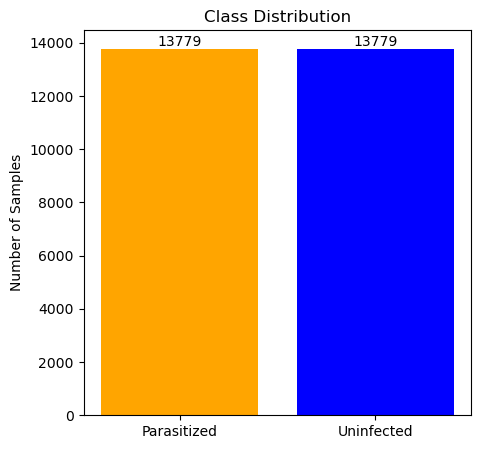

In [49]:
# Data for plotting
categories = ['Parasitized', 'Uninfected']
values     = [label.count(0), label.count(1)]
colors     = ['orange', 'blue']  

plt.figure(figsize = (5, 5))  
bars = plt.bar(categories, values, color = colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.title('Class Distribution')
plt.ylabel('Number of Samples')

plt.show()

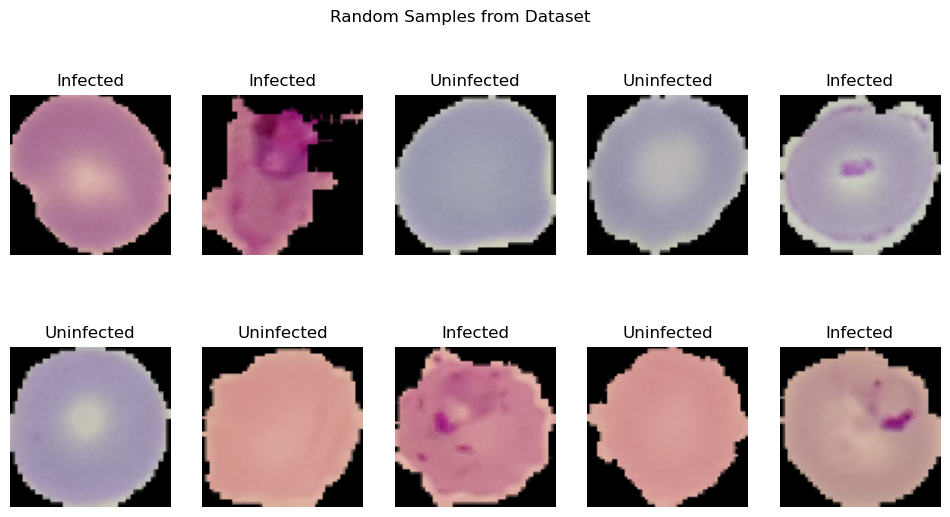

In [50]:
# Display some sample images:
def display_samples(samples, labels, title):
    plt.figure(figsize=(12, 6))
    for index, (image, label) in enumerate(zip(samples, labels)):
        plt.subplot(2, 5, index + 1)
        plt.imshow(image)
        plt.title('Infected' if label == 0 else 'Uninfected')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

samples_to_display = 10

random_indices = np.random.choice(len(dataset), samples_to_display, replace=False)
samples = [dataset[i] for i in random_indices]
sample_labels = [label[i] for i in random_indices]

display_samples(samples, sample_labels, "Random Samples from Dataset")

### Training & Validation

In [51]:
# Splitting the Dataset
X = np.array(dataset)
Y = to_categorical(np.array(label))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [52]:
# Data Augmentation
# Define the ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range    = 15,
    width_shift_range = 0.2,
    height_shift_range= 0.2,
    zoom_range        = 0.2,
    shear_range = 0.2,
    horizontal_flip   = True,
    vertical_flip     = True,
)

# to create the augmented data generator
augmented_data = data_generator.flow(X_train, y_train, batch_size = 64,shuffle = True)

In [53]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22046, 64, 64, 3)
y_train shape: (22046, 2)
X_test shape: (5512, 64, 64, 3)
y_test shape: (5512, 2)


### Xception

In [71]:
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.layers import BatchNormalization, Dropout

In [73]:
# Define the input shape of your images
INPUT_SHAPE = (224, 224, 3)  # Assuming your input images are 224x224 pixels with 3 channels (RGB)

# Load MobileNetV3 model with pre-trained weights, excluding the top (classification) layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the layers of the MobileNetV3 model
for layer in base_model.layers:
    layer.trainable = False

# Add your custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='sigmoid')(x)

# Combine the base MobileNetV3 model with custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Combine the base MobileNetV2 model with custom top layers
base_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
# Training the Model without Early Stopping
history = model.fit(
    augmented_data,
    verbose=1,
    epochs=45,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 64  # Number of batches per epoch
)

Epoch 1/45
344/344 [==============================] - 173s 462ms/step - loss: 0.6375 - accuracy: 0.7158 - val_loss: 0.6806 - val_accuracy: 0.6832
Epoch 2/45
344/344 [==============================] - 138s 401ms/step - loss: 0.5170 - accuracy: 0.7467 - val_loss: 0.5733 - val_accuracy: 0.7271
Epoch 3/45
344/344 [==============================] - 126s 367ms/step - loss: 0.5068 - accuracy: 0.7498 - val_loss: 0.7057 - val_accuracy: 0.6809
Epoch 4/45
344/344 [==============================] - 139s 404ms/step - loss: 0.4979 - accuracy: 0.7578 - val_loss: 0.5791 - val_accuracy: 0.7304
Epoch 5/45
344/344 [==============================] - 126s 365ms/step - loss: 0.4963 - accuracy: 0.7596 - val_loss: 0.5793 - val_accuracy: 0.7373
Epoch 6/45
344/344 [==============================] - 121s 351ms/step - loss: 0.4929 - accuracy: 0.7614 - val_loss: 0.5704 - val_accuracy: 0.7349
Epoch 7/45
344/344 [==============================] - 115s 335ms/step - loss: 0.4901 - accuracy: 0.7632 - val_loss: 0.4980 -

In [77]:
# Evaluate the model
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(f"Test Loss: {scores[0]:.5f}")

# Predict classes with the model
predictions = model.predict(np.array(X_test))
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to single-column format
y_test_single_column = np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
print(classification_report(y_test_single_column, predicted_classes))
print(confusion_matrix(y_test_single_column, predicted_classes))

Accuracy: 72.59%
Test Loss: 0.60010
173/173 [==============================] - 10s 37ms/step
              precision    recall  f1-score   support

           0       0.65      0.94      0.77      2703
           1       0.90      0.52      0.66      2809

    accuracy                           0.73      5512
   macro avg       0.78      0.73      0.71      5512
weighted avg       0.78      0.73      0.71      5512

[[2541  162]
 [1349 1460]]


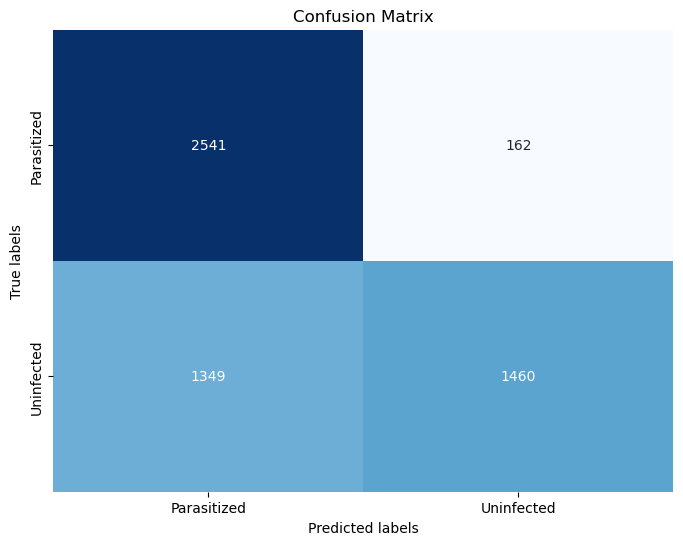

In [78]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_single_column, predicted_classes)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.show()

In [79]:
# Calculate the average training loss over all epochs
average_train_loss = np.mean(history.history['loss'])

# Get the training loss from the last epoch
final_train_loss = history.history['loss'][-1]

print(f"Average Training Loss: {average_train_loss:.5f}")
print(f"Final Training Loss: {final_train_loss:.5f}")

Average Training Loss: 0.48148
Final Training Loss: 0.46504


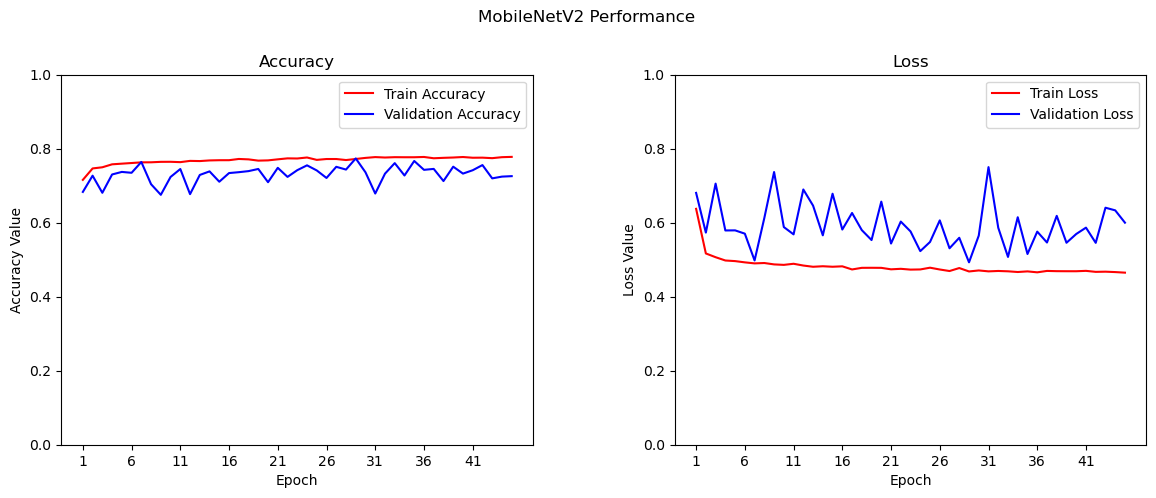

In [80]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('MobileNetV2 Performance', fontsize=12)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    # Extract the number of epochs and create a list of epoch numbers
    max_epoch = len(history.history['accuracy'])
    epoch_list = list(range(1, max_epoch + 1))

    # Plot training and validation accuracy
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy', color='red')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy', color='blue')
    ax1.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend(loc="best")
    ax1.set_ylim([0, 1])  # Set y-axis limits to [0, 1]

    # Plot training and validation loss
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss', color='red')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss', color='blue')
    ax2.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend(loc="best")
    ax2.set_ylim([0, 1])  # Set y-axis limits to [0, 1]

    # Display the plots
    plt.show()

# Call the function to plot
plot_training_history(history)
